###  Activity 1: All Possible Regressions

This is a quick assignment.  I would expect it to only take a couple of hours to complete. The start of this notebook develops the example.  You will then parallelize the exammple using `joblib`. 

Run this on a machine that has at least 4 cores. Typically this is your laptop. The ugrad machines are also OK. Google Colab is not adequate. Fill out the requested cells toward the bottom of the notebook.

**Due date**: Wednesday September 11, 2024, 9:00 pm EDT.

**Instructions for Submission**: Submit via Gradescope.

#### Preparing the Environment

You will need a couple of packages installed to make this work.  Stop your instance of jupyter lab and then run

```
conda install pandas pandoc
jupyter lab
```
At this point, you should be ready to go.

#### Example code

This is a Python reimplementation of the Section 3.4. in _Matloff_, Parallel Computing for Data Science. It is based on data from https://www.kaggle.com/divan0/multiple-linear-regression. The notebook asks the question what combination of variables best predict the price of a house.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

#importing dataset using panda
dataset = pd.read_csv('data/kc_house_data.csv') #NOTE: used to be: ../data/kc_house_data.csv
#to see what my dataset is comprised of
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


In [11]:
#dropping the id and date column
dataset = dataset.drop(['id','date'], axis=1)

# clean out NaN and inf values
dataset = dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(axis=1)] #NOTE: had to change to axis = 1

Let's first do a simple regression. How does square footage predict price? 

In [12]:
from sklearn.linear_model import LinearRegression

X = np.array(dataset.sqft_living)
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],1))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.4928817196006995


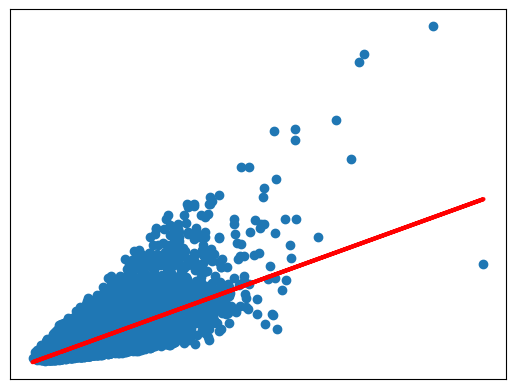

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

# scatter data
plt.plot(X,Y,'o')
# best fit line
y_pred = model.intercept_ + model.coef_ * X
plt.plot(X, y_pred, color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

We see that there is a strong correlation between square footage and house price.  The coefficient of determination measures the strength of the correlation and varies between 0 (no correlation) and 1.0 (perfectly correlated).

### Multiple Linear Regression

Adding more variables often improves the score.

In [104]:
X = np.array(dataset[['sqft_living','condition','yr_built']])
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],3))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.5249639858277426


but some variables are confounding

In [105]:
X = np.array(dataset[['zipcode','floors','waterfront']])
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],3))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.1358874997770878


This leads to a first parallel program.  What are the right set of variables? A brute force approach called _All Possible Regressions_ examines all combinations. So, let's build a big matrix that and we will regress on subsets.  We will look at all combinations of 1, 2, or 3 variables.

In [106]:
from itertools import combinations, chain

Y = np.array(dataset.price)
X = np.array(dataset.drop(['price'], axis=1))

## Let's choose all combinations of 1, 2, and 3 columns.
col_idxs = np.array(range(X.shape[1]))
combos = list(chain(combinations(col_idxs, 1), combinations(col_idxs, 2), combinations(col_idxs, 3)))

In [107]:
model = LinearRegression()

# do in a for loop (dumbest way)
r_sq_best = 0.0
for combo in combos:
    Xp = X[:,combo]
    model = model.fit(Xp,Y)
    r_sq = model.score(Xp,Y)
    if r_sq > r_sq_best:
        r_sq_best = r_sq
        combo_best = combo
    
print(r_sq_best, combo_best)

0.6095149101819037 (2, 6, 14)


The outcome is kind of crazy. The fields are `sqft-living`, `view`, and `latitude`. Latitude is probably a somewhat accurate proxy for wealth in this area, e.g. N of town richer than south of town. But, this is the kind of outcome that would not translate to other regions, i.e. is likely specific to this data.  _Neat_.

Back to performance.

In [108]:
%%timeit
model = LinearRegression()

r_sq_best = 0.0
for combo in combos:
    Xp = X[:,combo]
    model = model.fit(Xp,Y)
    r_sq = model.score(Xp,Y)
    if r_sq > r_sq_best:
        r_sq_best = r_sq
        combo_best = combo

896 ms ± 26.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's see if flattening the loop matters. Replace for loop with a list comprehension of all combination of variables.

In [109]:
def r_sq_regression (combo):
    Xp = X[:,combo]
    model = LinearRegression()
    model = model.fit(Xp,Y)
    return model.score(Xp,Y)

In [110]:
r_sq_list = [ (combo, r_sq_regression(combo)) for combo in combos ]
r_sq_arr = np.array(r_sq_list, dtype=object)
r_sq_idx = np.argmax(r_sq_arr[:,1])
print(r_sq_arr[r_sq_idx])

[(2, 6, 14) 0.6095149101819037]


In [111]:
%%timeit
r_sq_list = [ (combo, r_sq_regression(combo)) for combo in combos ]
r_sq_arr = np.array(r_sq_list, dtype=object)
r_sq_idx = np.argmax(r_sq_arr[:,1])

870 ms ± 9.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It didn't seem to help. But, this is a step toward parallelization.

### Exercise (This is the assignment)

1. Use `joblib.Parallel` and `joblib.delayed` to parallelize the computation of the calls to `r_sq_regression`. 
    1. In one cell, print the answer to verify that your parallel program is correct.
    2. In another cell time the computation. What is the speedup at `n_jobs=4`?
    3. Estimate the optimized fraction of the code ($p$) for this computation. Show your work.

In [44]:
from joblib import Parallel, delayed

# TODO code for 1A

# run in parallel
output_list = Parallel(n_jobs=4)(delayed(r_sq_regression)(combo) for combo in combos)
output_list_array = np.array(output_list, dtype=object)
max_index = np.argmax(r_sq_arr)
max_params = combos[max_index]
max_value = output_list_array[max_index]
print(max_params, max_value)

(2, 6, 14) 0.6095149101819037


In [49]:
%%timeit 
# TODO code for 1B 

output_list = Parallel(n_jobs=4)(delayed(r_sq_regression)(combo) for combo in combos)
output_list_array = np.array(output_list, dtype=object)
max_index = np.argmax(r_sq_arr)
max_params = combos[max_index]
max_value = output_list_array[max_index]

450 ms ± 5.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**TODO Answer for 1B**

2. Use the batch size parameter to vary the number of tasks in each batch from 1,2,...128 @ n_jobs=4. You will need to look at the joblib documentation to read up about batch size.
   1. Plot your results (use %timeit -o to capture output)
   2. Model the problem as having two performance components: a fixed startup cost per batch ($C_B$) and perfect parallelism.  Estimate the batch startup cost.

In [76]:
# code for 2A

def run_parallel_work(batch_size):
    output_list = Parallel(n_jobs=4, batch_size=batch_size)(delayed(r_sq_regression)(combo) for combo in combos)
    #TODO consider commenting out from here down
    output_list_array = np.array(output_list, dtype=object)
    max_index = np.argmax(output_list_array)
    max_params = combos[max_index]
    max_value = output_list_array[max_index]
    return max_params, max_value

time_results_2a = []
estimated_startup_costs = []
batch_sizes = range(1, 129)

for batch_size in batch_sizes:
    time_result = %timeit -o run_parallel_work(batch_size)
    time_results_2a.append(time_result.average)
    

836 ms ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
604 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
551 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
519 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
497 ms ± 42.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
499 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
494 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
483 ms ± 8.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
471 ms ± 4.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
476 ms ± 8.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
480 ms ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
465 ms ± 9.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
474 ms ± 6.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
465 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
452 ms ± 5.3 ms per loop (mean ± std. dev. of 7 ru

In [75]:
estimated_startup_costs

[0.0, 0.0, 0.0, 0.0]

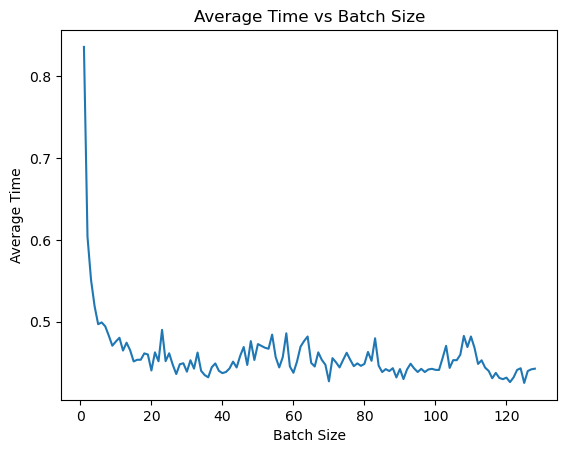

In [77]:
%matplotlib inline

# TODO plot for 2A

#plot time results vs batch size
plt.plot(batch_sizes, time_results_2a)
plt.xlabel('Batch Size')
plt.ylabel('Average Time')
plt.title('Average Time vs Batch Size')
plt.show()


In [88]:
# code for 2B

#estimate the startup costs


# For each experiment we known:
# total time = number of batches * (time per batch + startup cost per batch) (Equation for total running time)
# assuming that the time for completing a task in a batch is the same for all batches we can write:
# time per batch = time per task * batch size (Equation for time per batch)
# substituting the second equation into the first we get:
# total time = number of batches * (time per task * batch size + startup cost per batch)
# Distribute the right side:
# total time = number of batches * time per task * batch size + number of batches * startup cost per batch
# This equation has two unkonwns (1) time per task and (2) startup cost per batch, we fit a linear regression model to solve for these two unknowns

batch_sizes_np = np.array(batch_sizes)
number_of_batches_np = np.array([len(combos) / batch_size for batch_size in batch_sizes])
#make data matrix with first column as number of batches time batch size second column as number of batches
X = np.column_stack((number_of_batches_np * batch_sizes_np, number_of_batches_np))

y = np.array(time_results_2a)

#perform linear regression to solve for the coefficients
coefficients = np.linalg.lstsq(X, y, rcond=None)[0]

time_per_task = coefficients[0]
startup_cost = coefficients[1]

print('Time per task:', time_per_task)
print('Startup cost:', startup_cost)

Time per task: 0.00044869973711621024
Startup cost: 0.00036898338063918383


**TODO Answer for 2B**

3. Run the job with `prefer='threads'` and `prefer='processes'`. You do not need to vary batch size for this part. Which is more efficient?  Why? Consider our discussion of parallel threads in python.

In [114]:
# Code for 3

#From OH
#Can you use the tiem from above for time per task
#Take an average across number of batches to estimate C_b

#Run with threads
time_result_threads = %timeit -o Parallel(n_jobs=4, prefer='threads')(delayed(r_sq_regression)(combo) for combo in combos)
print('Time with threads:', time_result_threads.average)

#Run with processes
time_result_processes = %timeit -o Parallel(n_jobs=4, prefer='processes')(delayed(r_sq_regression)(combo) for combo in combos)
print('Time with processes:', time_result_processes.average)

996 ms ± 39.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time with threads: 0.9956220717135044
455 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time with processes: 0.4547164227135779


**TODO Answer to 3**